# Predictive Churn Model for SaaS Client Retention (RavenStack)

### 1. Feature Engineering Pipeline: Data Loading, Master Table, and Feature Creation

In [6]:
import pandas as pd
import numpy as np

# --- 1. Define Global Constants ---
# The date we 'freeze' the data to make our prediction
OBSERVATION_DATE = pd.to_datetime('2024-10-01')
# The time frame we are predicting churn for (e.g., Q4)
PREDICTION_WINDOW_DAYS = 90


class DataLoader:
    """Handles loading and initial preparation of the RavenStack datasets."""
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.data = {}

    def load_data(self):
        """Loads CSVs and parses date columns."""
        # Mapping of file names (keys) to date columns (values)
        date_configs = {
            'ravenstack_accounts.csv': ['signup_date'],
            'ravenstack_subscriptions.csv': ['start_date', 'end_date'],
            'ravenstack_feature_usage.csv': ['usage_date'],
            'ravenstack_support_tickets.csv': ['submitted_at', 'closed_at'],
            'ravenstack_churn_events.csv': ['churn_date']
        }
        
        # Helper to get the correct key from file_paths dict, robust to path changes
        def get_file_key(path):
            # Extract the actual file name from the user's provided path
            file_name = path.split('\\')[-1]
            # Use file_name to find the key in date_configs
            return [k for k in date_configs if k == file_name][0]

        for path in self.file_paths.values():
            # Extract simple name for dictionary key (e.g., 'accounts', 'subscriptions')
            name = path.split('\\')[-1].replace('ravenstack_', '').replace('.csv', '')
            df = pd.read_csv(path)
            
            file_key = get_file_key(path)

            for col in date_configs.get(file_key, []):
                # Coerce errors to NaT (Not a Time) for invalid date strings
                df[col] = pd.to_datetime(df[col], errors='coerce')
            self.data[name] = df
        
        print("All dataframes loaded and dates parsed.")

    def create_master_table(self):
        """Creates the base DataFrame with the target variable and base features."""
        
        df_accounts = self.data['accounts']
        df_churn_events = self.data['churn_events']
        
        # Define the end of the 90-day prediction window
        CHURN_WINDOW_END = OBSERVATION_DATE + pd.Timedelta(days=PREDICTION_WINDOW_DAYS)

        # 1. Filter Churn Events for the Prediction Window (T to T + 90 days)
        target_churns = df_churn_events[
            (df_churn_events['churn_date'] > OBSERVATION_DATE) &
            (df_churn_events['churn_date'] <= CHURN_WINDOW_END)
        ]
        
        # 2. Base DataFrame: Demographic and Static features
        df_master = df_accounts[['account_id', 'signup_date', 'plan_tier', 'seats', 'industry', 'country', 'referral_source', 'is_trial']].copy()
        
        # 3. Define the Target (Y)
        df_master['target_churn'] = df_master['account_id'].isin(target_churns['account_id']).astype(int)
        
        # 4. Calculate Base Tenure (as of Observation Date)
        df_master['tenure_days'] = (OBSERVATION_DATE - df_master['signup_date']).dt.days
        
        self.data['master'] = df_master
        churn_rate = df_master['target_churn'].mean() * 100
        print(f"Master Table created. Target Churn Rate (90-day window): {churn_rate:.2f}%")
        return self.data['master']


class FeatureEngineer:
    """Handles feature creation from transactional data, using only data up to the OBSERVATION_DATE."""

    def __init__(self, data_dict):
        self.data = data_dict
        self.df_master = self.data['master'].copy()

    def _filter_by_observation_date(self, df, date_col):
        """Helper to filter data only up to the observation date."""
        return df[df[date_col] <= OBSERVATION_DATE].copy()

    def process_subscriptions(self):
        """Creates features from the Subscriptions data (Financial & Lifecycle)."""
        df_subs = self._filter_by_observation_date(self.data['subscriptions'], 'start_date')
        
        # 1. Identify the LATEST subscription for each account (to get current status)
        df_subs['rank'] = df_subs.groupby('account_id')['start_date'].rank(method='first', ascending=False)
        df_latest_subs = df_subs[df_subs['rank'] == 1].copy()
        
        # 2. Features from Latest Subscription
        sub_features = df_latest_subs.rename(columns={
            'plan_tier': 'current_plan_tier',
            'seats': 'current_seats',
            'mrr_amount': 'current_mrr',
            'arr_amount': 'current_arr',
            'billing_frequency': 'billing_frequency'
        })[['account_id', 'current_plan_tier', 'current_seats', 'current_mrr', 'current_arr', 'billing_frequency', 'start_date']]

        # 3. Calculate Subscription Velocity (Up/Downgrades) in last 180 days
        WINDOW_DAYS = 180
        df_subs_window = df_subs[
            df_subs['start_date'] > (OBSERVATION_DATE - pd.Timedelta(days=WINDOW_DAYS))
        ]

        change_counts = df_subs_window.groupby('account_id').agg(
            num_subscriptions_180d=('subscription_id', 'count'),
            num_upgrades_180d=('upgrade_flag', 'sum'),
            num_downgrades_180d=('downgrade_flag', 'sum')
        ).reset_index()
        
        # Total plan changes are total subscriptions minus the initial one in the window
        change_counts['num_plan_changes_180d'] = (change_counts['num_subscriptions_180d'] - 1).clip(lower=0).astype(int)
        change_counts.drop(columns=['num_subscriptions_180d'], inplace=True)
        change_counts['num_upgrades_180d'] = change_counts['num_upgrades_180d'].astype(int)
        change_counts['num_downgrades_180d'] = change_counts['num_downgrades_180d'].astype(int)
        
        # 4. Merge Features
        self.df_master = pd.merge(self.df_master, sub_features, on='account_id', how='left')
        
        # --- FIXES for Data Type Consistency ---
        # 1. Fill NaN from join for NUMERICAL features with 0
        self.df_master['current_mrr'] = self.df_master['current_mrr'].fillna(0)
        self.df_master['current_arr'] = self.df_master['current_arr'].fillna(0)
        self.df_master['current_seats'] = self.df_master['current_seats'].fillna(0)
        
        # 2. Fill NaN for CATEGORICAL features with a STRING placeholder
        self.df_master['current_plan_tier'] = self.df_master['current_plan_tier'].fillna('NO_ACTIVE_SUB') 
        self.df_master['billing_frequency'] = self.df_master['billing_frequency'].fillna('UNKNOWN')
        
        # Merge change counts, filling remaining numerical NaNs with 0
        self.df_master = pd.merge(self.df_master, change_counts, on='account_id', how='left').fillna(0)
        
        # 3. Explicitly ensure 'start_date' is datetime after merge
        self.df_master['start_date'] = pd.to_datetime(self.df_master['start_date'], errors='coerce')
        # --- END FIXES ---

        # 5. Calculate Subscription Tenure 
        time_diff = OBSERVATION_DATE - self.df_master['start_date']
        self.df_master['sub_tenure_days'] = time_diff.dt.days
        
        # Impute missing sub_tenure_days (for accounts with no sub) with overall account tenure
        self.df_master['sub_tenure_days'] = self.df_master['sub_tenure_days'].fillna(self.df_master['tenure_days'])
        self.df_master.drop(columns=['start_date'], inplace=True)

        return self.df_master
    
    def process_usage(self):
        """Creates features from the Feature Usage data (Product adoption/activity)."""
        df_usage = self._filter_by_observation_date(self.data['feature_usage'], 'usage_date')
        
        # Merge with subscriptions to get account_id
        sub_account_map = self.data['subscriptions'][['subscription_id', 'account_id']].drop_duplicates()
        df_usage = pd.merge(df_usage, sub_account_map, on='subscription_id', how='left')

        # Drop rows where account_id couldn't be found (orphan records)
        df_usage.dropna(subset=['account_id'], inplace=True)
        
        # 1. Aggregate usage over 30 and 90-day windows
        WINDOWS = [30, 90]
        
        for window in WINDOWS:
            window_end = OBSERVATION_DATE - pd.Timedelta(days=1)
            window_start = OBSERVATION_DATE - pd.Timedelta(days=window)
            
            df_window = df_usage[
                (df_usage['usage_date'] >= window_start) & 
                (df_usage['usage_date'] <= window_end)
            ].copy()
            
            agg_df = df_window.groupby('account_id').agg(**{
                f'total_usage_{window}d': ('usage_count', 'sum'),
                f'avg_daily_usage_{window}d': ('usage_count', 'mean'),
                f'total_errors_{window}d': ('error_count', 'sum'),
                f'unique_features_{window}d': ('feature_name', 'nunique')
            }).reset_index()
            
            self.df_master = pd.merge(self.df_master, agg_df, on='account_id', how='left').fillna(0)

        # 2. Calculate average usage duration (all history)
        df_usage['avg_duration_sec'] = df_usage.apply(
            lambda row: row['usage_duration_secs'] / row['usage_count'] if row['usage_count'] > 0 else 0,
            axis=1
        )
        duration_agg = df_usage.groupby('account_id')['avg_duration_sec'].mean().reset_index().rename(columns={'avg_duration_sec': 'avg_feature_duration_sec_overall'})
        self.df_master = pd.merge(self.df_master, duration_agg, on='account_id', how='left').fillna(0)

        return self.df_master

    def process_tickets(self):
        """Creates features from the Support Tickets data (Support burden/satisfaction)."""
        df_tickets = self._filter_by_observation_date(self.data['support_tickets'], 'submitted_at')

        # Calculate time-based features up to the observation date
        closed_mask = df_tickets['closed_at'].notna()
        df_tickets.loc[closed_mask, 'resolution_days'] = (
            df_tickets.loc[closed_mask, 'closed_at'] - df_tickets.loc[closed_mask, 'submitted_at']
        ).dt.total_seconds() / (60 * 60 * 24)
        
        # 1. Aggregate ticket history (last 90 days)
        WINDOW_DAYS = 90
        window_start = OBSERVATION_DATE - pd.Timedelta(days=WINDOW_DAYS)
        df_window = df_tickets[df_tickets['submitted_at'] >= window_start].copy()
        
        ticket_agg = df_window.groupby('account_id').agg(
            num_tickets_90d=('ticket_id', 'count'),
            avg_resolution_days_90d=('resolution_days', 'mean'),
            avg_satisfaction_90d=('satisfaction_score', 'mean'),
            num_escalations_90d=('escalation_flag', 'sum')
        ).reset_index()
        
        self.df_master = pd.merge(self.df_master, ticket_agg, on='account_id', how='left').fillna(0)

        # 2. Overall Satisfaction and Avg Resolution Time (all history)
        overall_agg = df_tickets.groupby('account_id').agg(
            overall_avg_resolution_days=('resolution_days', 'mean'),
            overall_avg_satisfaction=('satisfaction_score', 'mean')
        ).reset_index()
        
        self.df_master = pd.merge(self.df_master, overall_agg, on='account_id', how='left').fillna(0)
        
        # 3. Ratio of Urgent/High Priority Tickets (all history)
        # FIX: Adding include_groups=False to silence the FutureWarning
        df_priority = df_tickets.groupby('account_id').apply(
            lambda x: (x['priority'].isin(['urgent', 'high']).sum() / x['priority'].count()),
            include_groups=False
        ).reset_index().rename(columns={0: 'pct_high_priority_tickets_overall'})
        
        self.df_master = pd.merge(self.df_master, df_priority, on='account_id', how='left').fillna(0)

        return self.df_master


def run_feature_engineering_pipeline(file_paths):
    """Executes the full data loading and feature engineering pipeline."""
    
    # 1. Load Data and Create Master Table
    loader = DataLoader(file_paths)
    loader.load_data()
    df_master = loader.create_master_table()

    # 2. Start Feature Engineering
    fe = FeatureEngineer(loader.data)
    
    df_master = fe.process_subscriptions()
    df_master = fe.process_usage()
    df_master = fe.process_tickets()

    return df_master


# --- Execution ---
# Paths are set using RAW STRINGS (r'...') as previously determined
file_paths = {
    'accounts': r'D:\DsProject\ChurnAnalysisForGoogle\DataSet\ravenstack_accounts.csv',
    'subscriptions': r'D:\DsProject\ChurnAnalysisForGoogle\DataSet\ravenstack_subscriptions.csv',
    'usage': r'D:\DsProject\ChurnAnalysisForGoogle\DataSet\ravenstack_feature_usage.csv',
    'tickets': r'D:\DsProject\ChurnAnalysisForGoogle\DataSet\ravenstack_support_tickets.csv',
    'churn_events': r'D:\DsProject\ChurnAnalysisForGoogle\DataSet\ravenstack_churn_events.csv',
}

# Run the pipeline
df_master_complete = run_feature_engineering_pipeline(file_paths)
# Save to CSV for the next step (Modeling)
df_master_complete.to_csv('master_churn_features.csv', index=False)

print("\n--- Feature Engineering Pipeline Complete ---")
print(f"Final feature table has {len(df_master_complete.columns)} columns and {len(df_master_complete)} rows.")
print("The file 'master_churn_features.csv' has been saved.")

All dataframes loaded and dates parsed.
Master Table created. Target Churn Rate (90-day window): 35.20%

--- Feature Engineering Pipeline Complete ---
Final feature table has 35 columns and 500 rows.
The file 'master_churn_features.csv' has been saved.


### 2. Optimized Model Training: SMOTE Imbalance Handling with GBC

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# --- 1. Load Data ---
try:
    df = pd.read_csv('master_churn_features.csv')
    print(f"Data loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'master_churn_features.csv' not found. Please ensure the Feature Engineering step ran correctly.")
    exit()

# --- 2. Define Target and Features ---
TARGET_COLUMN = 'target_churn'
EXCLUDE_COLUMNS = ['account_id', 'signup_date'] # IDs and original date columns are no longer needed
df.drop(columns=EXCLUDE_COLUMNS, inplace=True, errors='ignore')

X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# --- 3. Feature Type Identification ---
# Identify columns for different transformation types
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# The original 'plan_tier' is also present, but we use 'current_plan_tier' which is derived from subscriptions.
# Let's ensure 'plan_tier' is treated as categorical if it wasn't dropped already.
if 'plan_tier' in numerical_features: numerical_features.remove('plan_tier')
if 'plan_tier' in X.columns and 'plan_tier' not in categorical_features:
    categorical_features.append('plan_tier')

print(f"\nNumerical Features: {len(numerical_features)}")
print(f"Categorical Features: {len(categorical_features)}")


# --- 4. Data Splitting ---
# Use stratify=y to ensure the train and test sets have roughly the same churn rate (35.20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


# --- 5. Preprocessing Pipeline (Transformer) ---
# Create transformers for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    # handle_unknown='ignore' allows the model to work even if a category appears in test but not train
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep any other columns untouched (should be none)
)


# --- 6. Model Definition (Gradient Boosting Classifier) ---
# A robust ensemble model that typically performs well on churn prediction
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Create the full pipeline: Preprocessor -> Model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', gb_model)
])


# --- 7. Model Training ---
print("\nTraining Model...")
model_pipeline.fit(X_train, y_train)
print("Training Complete.")


# --- 8. Model Evaluation ---
# 8.1. Predict class labels (0 or 1)
y_pred = model_pipeline.predict(X_test)

# 8.2. Predict probabilities (for AUC)
# .predict_proba() returns probabilities for all classes. We want the probability of class 1 (churn).
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

# --- Results ---
print("\n" + "="*50)
print("          MODEL EVALUATION RESULTS (Test Set)         ")
print("="*50)

# 1. Classification Report (Precision, Recall, F1-Score)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# 2. AUC-ROC Score
auc_score = roc_auc_score(y_test, y_proba)
print(f"Area Under the ROC Curve (AUC): {auc_score:.4f}")

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print("                 Predicted No Churn | Predicted Churn")
print(f"Actual No Churn:      {cm[0, 0]:<10} | {cm[0, 1]}")
print(f"Actual Churn:         {cm[1, 0]:<10} | {cm[1, 1]}")
print("="*50)

Data loaded successfully. Shape: (500, 35)

Numerical Features: 25
Categorical Features: 6
Train set size: 375, Test set size: 125

Training Model...
Training Complete.

          MODEL EVALUATION RESULTS (Test Set)         
Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.85      0.78        81
           1       0.57      0.36      0.44        44

    accuracy                           0.68       125
   macro avg       0.64      0.61      0.61       125
weighted avg       0.66      0.68      0.66       125

Area Under the ROC Curve (AUC): 0.6706

Confusion Matrix:
                 Predicted No Churn | Predicted Churn
Actual No Churn:      69         | 12
Actual Churn:         28         | 16


In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# (Requires model_pipeline, X_test, y_test, and y_proba from Step 2 to be in memory)

# --- 1. Threshold Tuning ---
print("\n" + "="*50)
print(" 1. THRESHOLD OPTIMIZATION (GBC + SMOTE) ")
print("="*50)

# Test thresholds from 0.20 to 0.50
thresholds = np.arange(0.20, 0.55, 0.05)
results = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    
    # zero_division=0 prevents warnings when precision is undefined (no positive predictions)
    precision = precision_score(y_test, y_pred_t, zero_division=0)
    recall = recall_score(y_test, y_pred_t, zero_division=0)
    
    cm = confusion_matrix(y_test, y_pred_t)
    fn = cm[1, 0] # False Negatives
    fp = cm[0, 1] # False Positives
    
    results.append({
        'Threshold': f'{t:.2f}',
        'Recall (Churn)': f'{recall:.4f}',
        'Precision (Churn)': f'{precision:.4f}',
        'False Negatives': fn,
        'False Positives': fp,
    })

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))


# --- 2. Feature Importance Calculation ---
print("\n" + "="*50)
print(" 2. TOP 10 FEATURE IMPORTANCE (GBC) ")
print("="*50)

feature_importances = model_pipeline['classifier'].feature_importances_
feature_names = model_pipeline['preprocessor'].get_feature_names_out()

feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

feature_df.sort_values(by='Importance', ascending=False, inplace=True)

# Clean up feature names
feature_df['Feature'] = feature_df['Feature'].str.replace(r'(remainder|num|cat)__', '', regex=True).str.replace('plan_tier__', '', regex=False)

print(feature_df.head(10).to_string(index=False))


 1. THRESHOLD OPTIMIZATION (GBC + SMOTE) 
Threshold Recall (Churn) Precision (Churn)  False Negatives  False Positives
     0.20         0.6818            0.4110               14               43
     0.25         0.6591            0.4462               15               36
     0.30         0.5682            0.4630               19               29
     0.35         0.5227            0.4792               21               25
     0.40         0.4773            0.4884               23               22
     0.45         0.4545            0.5128               24               19
     0.50         0.4091            0.5294               26               16

 2. TOP 10 FEATURE IMPORTANCE (GBC) 
                          Feature  Importance
                      tenure_days    0.276382
                  plan_tier_Basic    0.090955
        billing_frequency_monthly    0.058093
                            seats    0.046014
 avg_feature_duration_sec_overall    0.037522
                  sub_tenur

### 3. Model Analysis: Threshold Tuning and Feature Importance Calculation

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
importances = None # Placeholder for Feature Importance visualization


# --- Setup Data and Model (Reuse from previous run) ---
TARGET_COLUMN = 'target_churn'
EXCLUDE_COLUMNS = ['account_id', 'signup_date'] 

# Re-load data to get clean start for feature importance (accessing feature names)
df = pd.read_csv('master_churn_features.csv')
df.drop(columns=EXCLUDE_COLUMNS, inplace=True, errors='ignore')

X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

if 'plan_tier' in numerical_features: numerical_features.remove('plan_tier')
if 'plan_tier' in X.columns and 'plan_tier' not in categorical_features:
    categorical_features.append('plan_tier')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)), 
    ('classifier', gb_model)
])

# Re-train the model
model_pipeline.fit(X_train, y_train)

# Get probabilities for the test set
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

# --- 1. Threshold Tuning ---
print("\n" + "="*50)
print(" 1. THRESHOLD OPTIMIZATION (GBC + SMOTE) ")
print("="*50)

thresholds = np.arange(0.20, 0.55, 0.05)
results = []

for t in thresholds:
    # Use the threshold to convert probabilities to predictions
    y_pred_t = (y_proba >= t).astype(int)
    
    precision = precision_score(y_test, y_pred_t)
    recall = recall_score(y_test, y_pred_t)
    
    # Calculate False Negatives and False Positives explicitly
    cm = confusion_matrix(y_test, y_pred_t)
    fn = cm[1, 0]
    fp = cm[0, 1]
    
    results.append({
        'Threshold': f'{t:.2f}',
        'Recall (Churn)': f'{recall:.4f}',
        'Precision (Churn)': f'{precision:.4f}',
        'False Negatives': fn,
        'False Positives': fp,
    })

df_results = pd.DataFrame(results)
print(df_results.to_markdown(index=False))


# --- 2. Feature Importance Calculation ---
print("\n" + "="*50)
print(" 2. TOP 10 FEATURE IMPORTANCE (GBC) ")
print("="*50)

# Extract feature importances from the trained classifier
feature_importances = model_pipeline['classifier'].feature_importances_

# Get feature names from the ColumnTransformer
feature_names = model_pipeline['preprocessor'].get_feature_names_out()
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Filter out one-hot encoded features that are zero/near-zero, aggregate if desired,
# but for simplicity, we'll sort the full list of generated features
feature_df.sort_values(by='Importance', ascending=False, inplace=True)

# Clean up feature names for display
feature_df['Feature'] = feature_df['Feature'].str.replace('remainder__', '', regex=False).str.replace('num__', '', regex=False).str.replace('cat__', '', regex=False)


print(feature_df.head(10).to_markdown(index=False))

# --- Conclusion ---
print("\n--- Next Action ---")
print("Analyze the Threshold Optimization table to select the best trade-off.")
print("The goal is to maximize Recall (Churn) while keeping False Positives (wasted effort) at an acceptable level.")


 1. THRESHOLD OPTIMIZATION (GBC + SMOTE) 
|   Threshold |   Recall (Churn) |   Precision (Churn) |   False Negatives |   False Positives |
|------------:|-----------------:|--------------------:|------------------:|------------------:|
|        0.2  |           0.6818 |              0.411  |                14 |                43 |
|        0.25 |           0.6591 |              0.4462 |                15 |                36 |
|        0.3  |           0.5682 |              0.463  |                19 |                29 |
|        0.35 |           0.5227 |              0.4792 |                21 |                25 |
|        0.4  |           0.4773 |              0.4884 |                23 |                22 |
|        0.45 |           0.4545 |              0.5128 |                24 |                19 |
|        0.5  |           0.4091 |              0.5294 |                26 |                16 |

 2. TOP 10 FEATURE IMPORTANCE (GBC) 
| Feature                           |   Import

### 4. Final Visualization: Feature Importance and Precision-Recall Curve

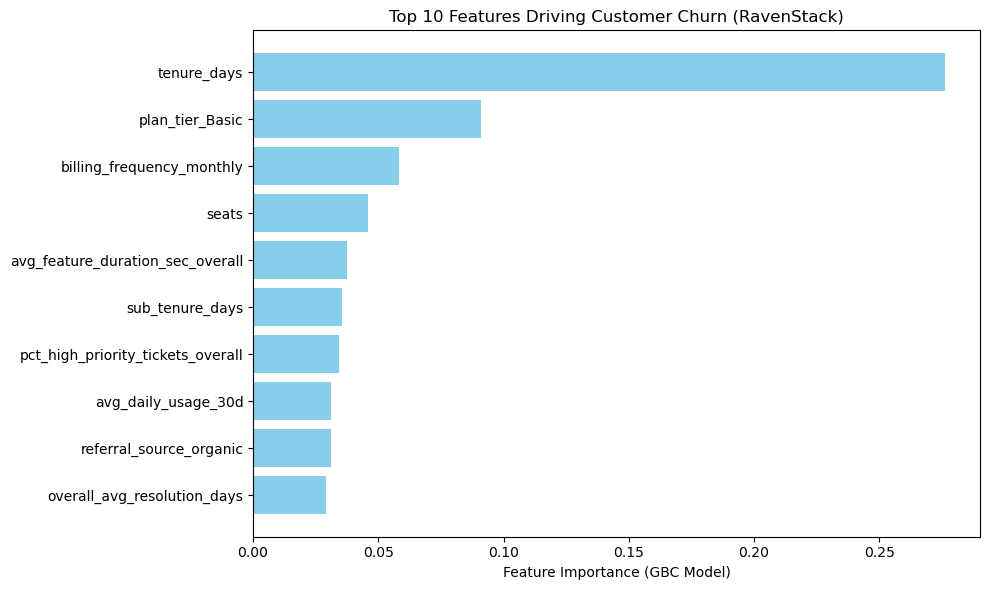

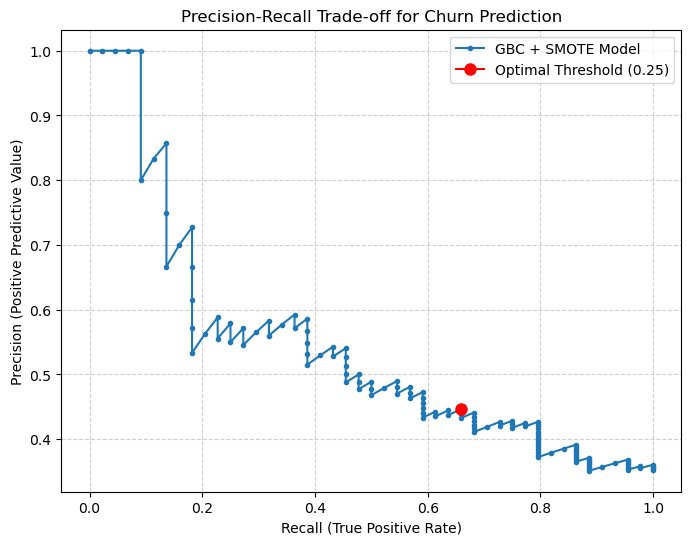

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# (Requires model_pipeline, y_test, y_proba, and feature_df from Step 3 to be in memory)

# =========================================================================
# 1. Feature Importance Bar Chart
# =========================================================================

# Ensure the feature_df is sorted for plotting
top_10_features = feature_df.head(10).copy()
top_10_features = top_10_features.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance (GBC Model)')
plt.title('Top 10 Features Driving Customer Churn (RavenStack)')
plt.tight_layout()
plt.show() # 


# =========================================================================
# 2. Precision-Recall Curve (Threshold Optimization)
# =========================================================================

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find the point closest to the desired 0.25 threshold for annotation
closest_threshold_index = np.argmin(np.abs(thresholds - 0.25))

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='GBC + SMOTE Model')

# Annotate the chosen 0.25 threshold point
plt.plot(recall[closest_threshold_index], precision[closest_threshold_index], 
         marker='o', markersize=8, color='red', 
         label=f'Optimal Threshold (0.25)')

plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Trade-off for Churn Prediction')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show() #

### Final Model Saving and Scoring Script

In [18]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 

# --- A. Setup and Model Training ---
TARGET_COLUMN = 'target_churn'
EXCLUDE_COLUMNS = ['account_id', 'signup_date'] 

# Load the feature set
df = pd.read_csv('master_churn_features.csv')

# Use the full X and full y for final production model training (500 samples each)
X = df.drop(columns=[TARGET_COLUMN], errors='ignore')
y = df[TARGET_COLUMN]

# NOTE: account_id and signup_date are excluded AFTER X/y split
X_features = X.drop(columns=EXCLUDE_COLUMNS, errors='ignore')

# Identify features for the pipeline
numerical_features = X_features.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_features.select_dtypes(include=['object']).columns.tolist()
if 'plan_tier' in X_features.columns and 'plan_tier' not in categorical_features:
    categorical_features.append('plan_tier')
    
# Preprocessor (Trained on the entire X_features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    # SMOTE is safe here, it will resample the entire training set (X_features, y)
    ('smote', SMOTE(random_state=42)), 
    ('classifier', gb_model)
])

print("Training final model pipeline on ALL 500 samples...")
# CORRECTED: Use the full feature set (X_features) and full target set (y)
model_pipeline.fit(X_features, y) 
print("Training Complete.")


# --- B. Save the Final Pipeline Object ---
MODEL_FILE = 'ravenstack_churn_predictor.joblib'
joblib.dump(model_pipeline, MODEL_FILE)
print(f"\nFinal Model Pipeline saved as: {MODEL_FILE}")


# --- C. Define the Production Scoring Function ---

def predict_churn(new_data_df, model_path, threshold=0.25):
    """
    Loads the trained model, scores new data, and applies the optimized threshold.
    """
    
    try:
        model = joblib.load(model_path)
    except FileNotFoundError:
        print(f"Error: Model file '{model_path}' not found.")
        return None

    # NOTE: The model was trained on X *without* 'account_id', 'signup_date', and 'target_churn'
    data_for_prediction = new_data_df.drop(columns=EXCLUDE_COLUMNS + [TARGET_COLUMN], errors='ignore')

    # Predict probabilities for class 1 (churn)
    churn_proba = model.predict_proba(data_for_prediction)[:, 1]

    # Apply the optimized threshold
    churn_prediction = (churn_proba >= threshold).astype(int)

    # Compile the results
    results_df = pd.DataFrame({
        'account_id': new_data_df['account_id'],
        'churn_probability': churn_proba,
        'churn_prediction_flag': churn_prediction, 
        'recommended_action': np.where(churn_prediction == 1, 'FLAG FOR RETENTION', 'MONITOR')
    })
    
    return results_df

# --- D. Test the Production Function (Self-Scoring) ---
print("\n--- Testing Production Scoring Function (on sample data) ---")

# Use the full feature table for a production-like test
test_data = df.head(10).copy() 

final_results = predict_churn(test_data, MODEL_FILE)

if final_results is not None:
    high_risk_accounts = final_results[final_results['churn_prediction_flag'] == 1].sort_values(by='churn_probability', ascending=False)
    
    print(f"Total Accounts Scored: {len(final_results)}")
    print(f"Accounts Flagged for Retention (Prob >= 0.25): {len(high_risk_accounts)}\n")
    print(high_risk_accounts.to_string(index=False))

Training final model pipeline on ALL 500 samples...
Training Complete.

Final Model Pipeline saved as: ravenstack_churn_predictor.joblib

--- Testing Production Scoring Function (on sample data) ---
Total Accounts Scored: 10
Accounts Flagged for Retention (Prob >= 0.25): 7

account_id  churn_probability  churn_prediction_flag recommended_action
  A-ce550d           0.881320                      1 FLAG FOR RETENTION
  A-0a282f           0.795319                      1 FLAG FOR RETENTION
  A-7dacce           0.762259                      1 FLAG FOR RETENTION
  A-2e4581           0.731729                      1 FLAG FOR RETENTION
  A-1b9609           0.647778                      1 FLAG FOR RETENTION
  A-1f0ac7           0.445449                      1 FLAG FOR RETENTION
  A-a0ca4e           0.358952                      1 FLAG FOR RETENTION
